# <center>组分析过程</center>

In [1]:
import sys
sys.path.append('/home/hcp/anaconda3/envs/xj/lib/python3.8/site-packages')
import os
import numpy as np
import pandas as pd
from glob import glob
from bids import BIDSLayout
from nilearn import plotting
import matplotlib.pyplot as plt
from nilearn.image import mean_img
from nilearn.glm import threshold_stats_img
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.second_level import SecondLevelModel
from nilearn.reporting import make_glm_report, get_clusters_table
from nilearn.plotting import plot_stat_map, plot_anat, plot_img, show, plot_glass_brain, plot_design_matrix, plot_contrast_matrix

/home/hcp/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [10]:
def build_Subs():
    path = '/mnt/sdb1/Judge-fMRI/Data/AnalysisData/Information_of_trials.txt'
    with open(path, 'r', encoding='utf-8') as f:
        f_data = f.read().split('\n')
        data = f_data[3:]
        judge_subs = f_data[1].split(',')
        layperson_subs = f_data[2].split(',')

    build_subs_dict = {}
    for i in data:
        li = i.split(',')
        build_subs_dict[li[0]] = []
        for j in range(int((len(li)-1)/2)):
            build_subs_dict[li[0]].append([li[2*j+1], li[(j+1)*2]])

    return judge_subs, layperson_subs, build_subs_dict

judge_subs, layperson_subs, build_subs_dict = build_Subs()
print(judge_subs)
print(layperson_subs)

['001', '002', '003', '005', '006', '007', '008', '009', '010', '014', '015', '019', '022', '023', '024', '025']
['031', '033', '034', '035', '038', '042', '044', '046', '047', '050', '051', '053']


In [4]:
outdir = '/mnt/sdb1/Judge-fMRI/Scripts/AnalysisScripts/GLM-FirstLevelAnalysis/results_drop_trials_only_on_DesignMatrix_0620'
list_z_maps = sorted(glob(os.path.join(outdir, '*.nii.gz')))
print(len(list_z_maps))
list_z_maps

84


['/mnt/sdb1/Judge-fMRI/Scripts/AnalysisScripts/GLM-FirstLevelAnalysis/results_drop_trials_only_on_DesignMatrix_0620/sub-001-common_zmap.nii.gz',
 '/mnt/sdb1/Judge-fMRI/Scripts/AnalysisScripts/GLM-FirstLevelAnalysis/results_drop_trials_only_on_DesignMatrix_0620/sub-001-legal_zmap.nii.gz',
 '/mnt/sdb1/Judge-fMRI/Scripts/AnalysisScripts/GLM-FirstLevelAnalysis/results_drop_trials_only_on_DesignMatrix_0620/sub-001-moral_zmap.nii.gz',
 '/mnt/sdb1/Judge-fMRI/Scripts/AnalysisScripts/GLM-FirstLevelAnalysis/results_drop_trials_only_on_DesignMatrix_0620/sub-002-common_zmap.nii.gz',
 '/mnt/sdb1/Judge-fMRI/Scripts/AnalysisScripts/GLM-FirstLevelAnalysis/results_drop_trials_only_on_DesignMatrix_0620/sub-002-legal_zmap.nii.gz',
 '/mnt/sdb1/Judge-fMRI/Scripts/AnalysisScripts/GLM-FirstLevelAnalysis/results_drop_trials_only_on_DesignMatrix_0620/sub-002-moral_zmap.nii.gz',
 '/mnt/sdb1/Judge-fMRI/Scripts/AnalysisScripts/GLM-FirstLevelAnalysis/results_drop_trials_only_on_DesignMatrix_0620/sub-003-common_zma

/tmp/ipykernel_1061381/134723350.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_right = sub_means.replace({True :1 ,False :0})


KeyboardInterrupt: 

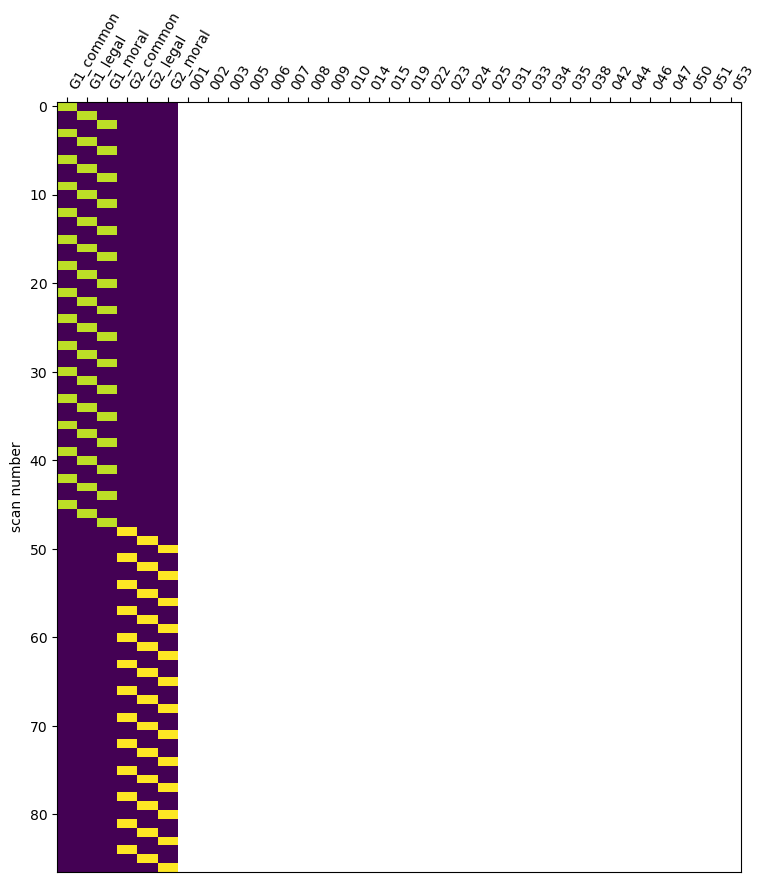

In [11]:
n1 = np.tile(np.eye(3), (13, 1))
n0 = np.zeros(n1.shape)
X1 = np.concatenate((n1, n0), 1)
X2 = np.concatenate((n0, n1), 1)
#TODO：未接受法律教育者比接受过法律教育者多2名
n11 = np.tile(np.eye(3), (3, 1))
n00 = np.zeros(n11.shape)
X1_5 = np.concatenate((n11, n00), 1)
X = np.concatenate((X1, X1_5, X2), 0).astype(int)

# X = np.concatenate((X1, X2), 0).astype(int)
X_left = pd.DataFrame(X)
sub_id = []
for s in range(len(judge_subs + layperson_subs)):
    sub_id.extend([s]*3)
sub_means = pd.DataFrame([sub_id==x for x in np.unique(sub_id)]).T
X_right = sub_means.replace({True :1 ,False :0})
X = pd.concat([X_left, X_right], axis=1)
X.columns = ['G1_common', 'G1_legal', 'G1_moral'] + ['G2_common', 'G2_legal', 'G2_moral'] + judge_subs + layperson_subs
design_matrix = X
plot_design_matrix(design_matrix)
plt.show()
design_matrix

In [ ]:
n1 = np.tile(np.eye(3), (13, 1))
n0 = np.zeros(n1.shape)
X1 = np.concatenate((n1, n0), 1)
X2 = np.concatenate((n0, n1), 1)
#TODO：未接受法律教育者比接受过法律教育者多2名
n11 = np.tile(np.eye(3), (3, 1))
n00 = np.zeros(n11.shape)
X1_5 = np.concatenate((n11, n00), 1)
X = np.concatenate((X1, X1_5, X2), 0).astype(int)

# X = np.concatenate((X1, X2), 0).astype(int)
X_left = pd.DataFrame(X)
sub_id = []
for s in range(len(judge_subs + layperson_subs)):
    sub_id.extend([s]*3)
sub_means = pd.DataFrame([sub_id==x for x in np.unique(sub_id)]).T
X_right = sub_means.replace({True :1 ,False :0})
X = pd.concat([X_left, X_right], axis=1)
X.columns = ['G1_common', 'G1_legal', 'G1_moral'] + ['G2_common', 'G2_legal', 'G2_moral'] + judge_subs + layperson_subs
design_matrix = X
plot_design_matrix(design_matrix)
plt.show()
design_matrix

In [6]:
second_level_model = SecondLevelModel(n_jobs=2).fit(list_z_maps, design_matrix=design_matrix)

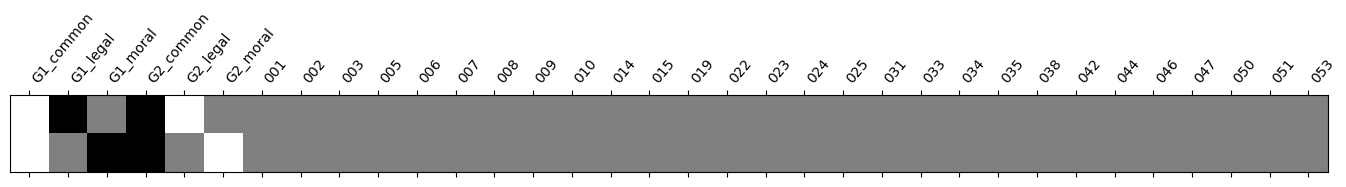

array([[ 1., -1.,  0., -1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0., -1., -1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [7]:
conditions = {"one": np.zeros(6 + len(judge_subs + layperson_subs)), "two": np.zeros(6 + len(judge_subs + layperson_subs))}
conditions['one'][0:5] = [1, -1, 0, -1, 1]
conditions['two'][0:6] = [1, 0, -1, -1, 0, 1]
contrast_matrix = np.vstack((conditions["one"], conditions["two"]))
plot_contrast_matrix(contrast_matrix, design_matrix)
plt.show()
contrast_matrix

In [8]:
z_map_group = second_level_model.compute_contrast(contrast_matrix, output_type='z_score')

ValueError: design_matrix does not match the number of maps considered. 87 rows in design matrix do not match with 84 maps.

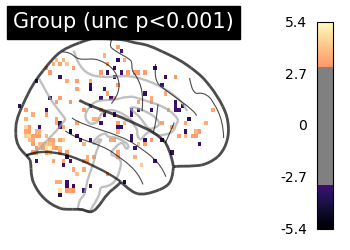

The unc threshold is 3.09


In [8]:
from scipy.stats import norm
p001_unc = norm.isf(0.001)

plotting.plot_glass_brain(z_map_group, colorbar=True, threshold=p001_unc,
                          title='Group (unc p<0.001)',
                          plot_abs=False, display_mode='x', cmap='magma')
plotting.show()
print(f"The unc threshold is {p001_unc:.3g}")

In [9]:
thresholded_map, threshold = threshold_stats_img(
    z_map_group, alpha=.05, height_control='fdr', cluster_threshold=0)#000000000000000000000
print(f"The FDR=.05 threshold is {threshold:.3g}")

The FDR=.05 threshold is 4.79


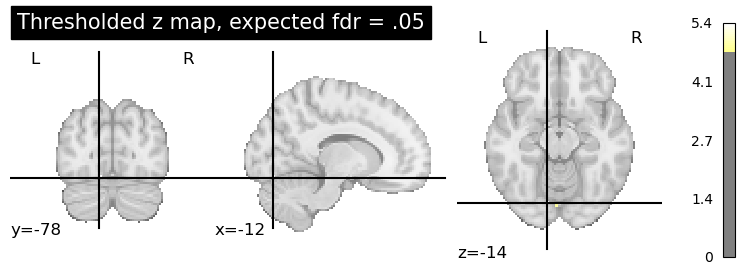

In [10]:
plotting.plot_stat_map(
    thresholded_map,
    title="Thresholded z map, expected fdr = .05",
    threshold=threshold,
)

In [11]:
table = get_clusters_table(thresholded_map, stat_threshold=0, cluster_threshold=0)#TODO:此时的stat_threshold小于上面的阈值时都无效
table

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)
0,1,-12.5,-78.5,-14.75,5.406791,33
1,2,-3.5,-81.5,-14.75,4.859237,33
2,3,29.5,-69.5,-52.25,4.790653,33


In [12]:
name = "Mixed_Moral_common_legal"
thresholded_map.to_filename(name + ".nii.gz")

In [13]:
table.to_csv(name + ".csv")

In [14]:
from atlasreader import create_output
create_output(name + ".nii.gz", cluster_extent=0)

The Python package you are importing, AtlasReader, is licensed under the
BSD-3 license; however, the atlases it uses are separately licensed under more
restrictive frameworks.
By using AtlasReader, you agree to abide by the license terms of the
individual atlases. Information on these terms can be found online at:
https://github.com/miykael/atlasreader/tree/master/atlasreader/data



In [15]:
peak_info = pd.read_csv(name + '_peaks.csv')
peak_info

,cluster_id,peak_x,peak_y,peak_z,peak_value,volume_mm,aal,desikan_killiany,harvard_oxford
0,1,29.5,-69.5,-52.25,4.79065,33.75,Cerebelum_8_R,Right-Cerebellum-Cortex,0% no_label
1,2,-3.5,-81.5,-14.75,4.85924,33.75,Cerebelum_6_L,Unknown,36.0% Left_Lingual_Gyrus; 7.0% Left_Occipital_...
2,3,-12.5,-78.5,-14.75,5.40679,33.75,Lingual_L,ctx-lh-lingual,29.0% Left_Lingual_Gyrus; 25.0% Left_Occipital...


In [16]:
cluster_info = pd.read_csv(name + '_clusters.csv')
cluster_info

,cluster_id,peak_x,peak_y,peak_z,cluster_mean,volume_mm,aal,desikan_killiany,harvard_oxford
0,1,29.5,-69.5,-52.25,4.79065,33.75,100.00% Cerebelum_8_R,100.00% Right-Cerebellum-Cortex,100.00% no_label
1,2,-3.5,-81.5,-14.75,4.85924,33.75,100.00% Cerebelum_6_L,100.00% Unknown,100.00% Left_Lingual_Gyrus
2,3,-12.5,-78.5,-14.75,5.40679,33.75,100.00% Lingual_L,100.00% ctx-lh-lingual,100.00% Left_Lingual_Gyrus


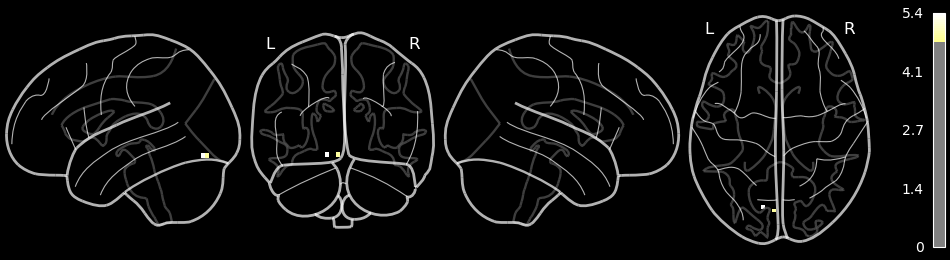

In [17]:
from IPython.display import Image
Image(name + ".png")